In [1]:
import sympy as sp

# Define symbols
I = sp.I  # Imaginary unit
nu_E = sp.Symbol('nu_E', real=True)  # Neutral element to avoid zero

def FactorChiMatrix(expr):
    if isinstance(expr, sp.Matrix):
        # Exponential element-wise for non-square matrices, matrix exponential for square matrices
        if expr.shape[0] == expr.shape[1]:
            return expr.exp()
        else:
            return expr.applyfunc(sp.exp)
    else:
        # Standard exponential for scalar expressions
        return sp.exp(sp.simplify(expr))

def safe_division(num, denom):
    """Safeguards division to avoid ZeroDivisionError by replacing zero with nu_E."""
    return num / (denom if denom != 0 else nu_E)

def expand_to_shape(mat, target_shape):
    """ Expands the matrix `mat` by padding with zeros to match the `target_shape`. """
    expanded_matrix = sp.zeros(*target_shape)
    for i in range(min(target_shape[0], mat.shape[0])):
        for j in range(min(target_shape[1], mat.shape[1])):
            expanded_matrix[i, j] = mat[i, j]
    return expanded_matrix

def MMAUpdated(x, alpha, rho, theta, eta):
    # Calculate phi, sigma, omega
    phi = sp.Matrix([sp.diff(alpha, xi) + sp.diff(rho, xi) + eta * sp.diff(alpha, xi) for xi in x])
    sigma = safe_division(1.0, theta)
    omega = -2.0 * rho

    # Ensure correct dimensions for derivatives
    phi_diff = sp.Matrix([
        [sp.diff(phi[i], xi) if isinstance(sp.diff(phi[i], xi), sp.Basic) else sp.zeros(len(x), 1) for xi in x]
        for i in range(len(phi))
    ])
    phi_diff_3 = sp.Matrix([
        [elem**3 if not elem.is_zero else nu_E for elem in row]
        for row in phi_diff.tolist()
    ])

    # Define target shape for all matrix terms
    target_shape = (len(x), len(x))

    # Construct TrU with matching dimensions
    term1 = expand_to_shape(sigma * FactorChiMatrix(phi), target_shape)
    term2 = expand_to_shape(sigma**2 / 3.0 * (3.0 * alpha + omega * theta) * FactorChiMatrix(phi_diff), target_shape)
    term3 = expand_to_shape(sigma**3 / 5.0 * (5.0 * alpha * omega**2 + safe_division(omega, rho) * (alpha + omega * theta)**2) * FactorChiMatrix(phi_diff_3), target_shape)

    # Compute the trace separately and use it in a compatible manner
    phi_trace = phi.trace() if phi.shape[0] == phi.shape[1] else sum([phi[i, i] for i in range(min(phi.shape))])
    term4 = expand_to_shape(I * sigma**2 * phi_trace * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term5 = expand_to_shape(I * sigma**3 / 6.0 * sp.log(rho + 0.5 * theta * alpha + nu_E) * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term6 = expand_to_shape(sp.Matrix([
        [sigma**4 / 2.0 * elem**4 if not elem.is_zero else nu_E for xi, row in zip(x, phi_diff.tolist()) for elem in row]
    ]).reshape(target_shape[0], target_shape[1]), target_shape)

    # Ensure terms are made compatible for addition
    term4 = term4.applyfunc(lambda e: sp.simplify(e)) if isinstance(term4, sp.Matrix) else term4
    term5 = term5.applyfunc(lambda e: sp.simplify(e)) if isinstance(term5, sp.Matrix) else term5
    term6 = term6.applyfunc(lambda e: sp.simplify(e)) if isinstance(term6, sp.Matrix) else term6

    # Add terms ensuring they are compatible
    TrU = term1 + term2 + term3 + term4 + term5 + term6

    return TrU

def tolforgrowthhSFI(x, sigma):
    return True  # Placeholder

def PTSeedDistribution(xx, ms):
    return sp.sqrt(ms[0]) * xx[0, 0] + sp.sqrt(ms[1]) * xx[1, 0]

def TransformedIntTimes(x, sigma, M):
    # Assuming x is a NxM matrix
    solution_set = [xi**2 for xi in x[:, 0]]  # Adjusted to match dimensions

    Ms = lambda M, xi, sigma: sp.eye(x.shape[1])  # Placeholder returning identity matrix
    T = lambda xi, sigma: 1                       # Placeholder for T function

    Ms_matrix = Ms(M, x[0, :], sigma)
    solution_set_matrix = sp.Matrix(solution_set)

    # Ensure shapes are compatible for multiplication and make square for exponentiation
    if Ms_matrix.shape[1] != solution_set_matrix.shape[0]:
        solution_set_matrix = sp.Matrix.vstack(*[solution_set_matrix] * Ms_matrix.shape[1])

    exp_arg = safe_division(sigma * Ms_matrix * solution_set_matrix, T(x[0, 0], sigma))

    # Ensure exp_arg is square
    exp_arg_square = sp.Matrix.eye(exp_arg.shape[0]) * exp_arg[0] if exp_arg.shape != (Ms_matrix.shape[0], Ms_matrix.shape[0]) else exp_arg

    return sp.simplify(sp.exp(exp_arg_square))

# Example usage
alpha, rho, theta, eta = sp.symbols('alpha rho theta eta')
ms = [sp.Symbol('m1'), sp.Symbol('m2')]  # List of symbolic masses

# Define x as a 2x1 matrix for simplicity
x = sp.Matrix([sp.Symbol('x1'), sp.Symbol('x2')])

# Test the MMAUpdated function with scalar alpha, rho, theta, and eta
alpha_expr = alpha  # Scalar
rho_expr = rho      # Scalar
theta_expr = theta  # Scalar
eta_value = eta     # Scalar

# Call the MMAUpdated function
result = MMAUpdated(x, alpha_expr, rho_expr, theta_expr, eta_value)
print(result)

# Perform a PTSeedDistribution calculation
pt_result = PTSeedDistribution(x, ms)
print(pt_result)

# Perform transformed integration times
# Define a 2x2 symbolic matrix for x
x_matrix = sp.Matrix([[sp.Symbol('x11'), sp.Symbol('x12')], [sp.Symbol('x21'), sp.Symbol('x22')]])
transformed_result = TransformedIntTimes(x_matrix, sp.Symbol('sigma'), sp.Symbol('M'))
print(transformed_result)

Matrix([[nu_E + 1.0/theta + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(exp(2*nu_E)/2 + 1/2)/theta**3 + 0.166666666666667*I*log(0.5*alpha*theta + nu_E + rho)/theta**3, nu_E + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(exp(2*nu_E)/2 - 1/2)/theta**3 + 0.166666666666667*I*log(0.5*alpha*theta + nu_E + rho)/theta**3], [nu_E + 1.0/theta + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(exp(2*nu_E)/2 - 1/2)/theta**3 + 0.166666666666667*I*log(0.5*alpha*theta + nu_E + rho)/theta**3, nu_E + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(exp(2*nu_E)/2 + 1/2)/theta**3 + 0.166666666666667*I*log(0.5*alpha*theta + nu_E + rho)/theta**3]])
sqrt(m1)*x1 + sqrt(m2)*x2
Matrix([[exp(sigma*x11**2), 0], [0, exp(sigma*x11**2)]])


To apply the `MMAUpdated` analysis program to the string theory programs, we need to connect the foundational elements of the string theory with the `MMAUpdated` function. The analysis should leverage the mathematical constructs of string theory such as oscillations, compactification, and gauge transformations into the deprogrammed zero methodology.

### Integrating MMA Analysis into String Theory Context

We'll incorporate the `MMAUpdated` function to analyze string theory concepts including the vibrations, compactifications, and mapping of coordinates in higher-dimensional spaces.

### Step-by-step Integration

1. **String Theory Mode Expansion**:
   The mode expansion of strings in string theory involves vibrating modes represented by `X`:
   \[
   X^{\mu}(\tau, \sigma) = x^{\mu} + \frac{2\alpha^\prime}{r}\left(\langle \partial \theta \times \vec{r}_{\infty} \rangle \cap \left\langle \partial x \times \theta_\infty \right\rangle \right) + i\sqrt{\frac{\alpha^\prime}{2}}\sum_{n=1}^{\infty}\frac{1}{\sqrt{n}}\left(\alpha_{n}^{\mu} e^{-in\left(\tau-\sigma\right)}+\tilde{\alpha}_{n}^{\mu} e^{-in\left(\tau+\sigma\right)} \right)
   \]

In [ ]:
  import sympy as sp

   # Define necessary string theory symbols
   tau, sigma, alpha = sp.symbols('tau sigma alpha')
   mu, r, theta, eta = sp.symbols('mu r theta eta')

   # Define vibrations and compactifications
   def string_theory_vibrations(x, alpha, rho, theta, eta):
       return MMAUpdated(x, alpha, rho, theta, eta)

IndentationError: unexpected indent (<ipython-input-2-27c72412ef7b>, line 4)

In [2]:
import sympy as sp

# Define symbols
I = sp.I  # Imaginary unit
nu_E = sp.Symbol('nu_E', real=True)  # Neutral element to avoid zero

def FactorChiMatrix(expr):
    if isinstance(expr, sp.Matrix):
        if expr.shape[0] == expr.shape[1]:
            return expr.exp()
        else:
            return expr.applyfunc(sp.exp)
    else:
        return sp.exp(sp.simplify(expr))

def safe_division(num, denom):
    """Safeguards division to avoid ZeroDivisionError by replacing zero with nu_E."""
    return num / (denom if denom != 0 else nu_E)

def expand_to_shape(mat, target_shape):
    """ Expands the matrix `mat` by padding with zeros to match the `target_shape`. """
    expanded_matrix = sp.zeros(*target_shape)
    for i in range(min(target_shape[0], mat.shape[0])):
        for j in range(min(target_shape[1], mat.shape[1])):
            expanded_matrix[i, j] = mat[i, j]
    return expanded_matrix

def MMAUpdated(x, alpha, rho, theta, eta):
    phi = sp.Matrix([sp.diff(alpha, xi) + sp.diff(rho, xi) + eta * sp.diff(alpha, xi) for xi in x])
    sigma = safe_division(1.0, theta)
    omega = -2.0 * rho

    phi_diff = sp.Matrix([
        [sp.diff(phi[i], xi) if isinstance(sp.diff(phi[i], xi), sp.Basic) else sp.zeros(len(x), 1) for xi in x]
        for i in range(len(phi))
    ])
    phi_diff_3 = sp.Matrix([
        [elem**3 if not elem.is_zero else nu_E for elem in row]
        for row in phi_diff.tolist()
    ])

    target_shape = (len(x), len(x))

    term1 = expand_to_shape(sigma * FactorChiMatrix(phi), target_shape)
    term2 = expand_to_shape(sigma**2 / 3.0 * (3.0 * alpha + omega * theta) * FactorChiMatrix(phi_diff), target_shape)
    term3 = expand_to_shape(sigma**3 / 5.0 * (5.0 * alpha * omega**2 + safe_division(omega, rho) * (alpha + omega * theta)**2) * FactorChiMatrix(phi_diff_3), target_shape)

    phi_trace = phi.trace() if phi.shape[0] == phi.shape[1] else sum([phi[i, i] for i in range(min(phi.shape))])
    term4 = expand_to_shape(I * sigma**2 * phi_trace * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term5 = expand_to_shape(I * sigma**3 / 6.0 * sp.log(rho + 0.5 * theta * alpha + nu_E) * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term6 = expand_to_shape(sp.Matrix([
        [sigma**4 / 2.0 * elem**4 if not elem.is_zero else nu_E for xi, row in zip(x, phi_diff.tolist()) for elem in row]
    ]).reshape(target_shape[0], target_shape[1]), target_shape)

    term4 = term4.applyfunc(lambda e: sp.simplify(e)) if isinstance(term4, sp.Matrix) else term4
    term5 = term5.applyfunc(lambda e: sp.simplify(e)) if isinstance(term5, sp.Matrix) else term5
    term6 = term6.applyfunc(lambda e: sp.simplify(e)) if isinstance(term6, sp.Matrix) else term6

    TrU = term1 + term2 + term3 + term4 + term5 + term6

    return TrU

def tolforgrowthhSFI(x, sigma):
    return True  # Placeholder

def PTSeedDistribution(xx, ms):
    return sp.sqrt(ms[0]) * xx[0, 0] + sp.sqrt(ms[1]) * xx[1, 0]

def TransformedIntTimes(x, sigma, M):
    solution_set = [xi**2 for xi in x[:, 0]]  # Adjusted to match dimensions

    Ms = lambda M, xi, sigma: sp.eye(x.shape[1])  # Placeholder returning identity matrix
    T = lambda xi, sigma: 1  # Placeholder for T function

    Ms_matrix = Ms(M, x[0, :], sigma)
    solution_set_matrix = sp.Matrix(solution_set)

    if Ms_matrix.shape[1] != solution_set_matrix.shape[0]:
        solution_set_matrix = sp.Matrix.vstack(*[solution_set_matrix] * Ms_matrix.shape[1])

    exp_arg = safe_division(sigma * Ms_matrix * solution_set_matrix, T(x[0, 0], sigma))

    exp_arg_square = sp.Matrix.eye(exp_arg.shape[0]) * exp_arg[0] if exp_arg.shape != (Ms_matrix.shape[0], Ms_matrix.shape[0]) else exp_arg

    return sp.simplify(sp.exp(exp_arg_square))

# Define symbols specifically for String Theory
alpha_prime, tau, sigma = sp.symbols('alpha_prime tau sigma')

# Define example inputs
x = sp.Matrix([sp.Symbol('x1'), sp.Symbol('x2')])
alpha_expr = alpha  # Scalar
rho_expr = rho      # Scalar
theta_expr = theta  # Scalar
eta_value = eta     # Scalar

# Apply the MMAUpdated function to String Theory scenario
result = MMAUpdated(x, alpha_expr, rho_expr, theta_expr, eta_value)
print(result)

# Perform a PTSeedDistribution calculation
ms = [sp.Symbol('m1'), sp.Symbol('m2')]
pt_result = PTSeedDistribution(x, ms)
print(pt_result)

# Perform transformed integration times
x_matrix = sp.Matrix([[sp.Symbol('x11'), sp.Symbol('x12')], [sp.Symbol('x21'), sp.Symbol('x22')]])
transformed_result = TransformedIntTimes(x_matrix, sp.Symbol('sigma'), sp.Symbol('M'))
print(transformed_result)

Matrix([[nu_E + 1.0/theta + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(exp(2*nu_E)/2 + 1/2)/theta**3 + 0.166666666666667*I*log(0.5*alpha*theta + nu_E + rho)/theta**3, nu_E + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(exp(2*nu_E)/2 - 1/2)/theta**3 + 0.166666666666667*I*log(0.5*alpha*theta + nu_E + rho)/theta**3], [nu_E + 1.0/theta + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(exp(2*nu_E)/2 - 1/2)/theta**3 + 0.166666666666667*I*log(0.5*alpha*theta + nu_E + rho)/theta**3, nu_E + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(exp(2*nu_E)/2 + 1/2)/theta**3 + 0.166666666666667*I*log(0.5*alpha*theta + nu_E + rho)/theta**3]])
sqrt(m1)*x1 + sqrt(m2)*x2
Matrix([[exp(sigma*x11**2), 0], [0, exp(sigma*x11**2)]])


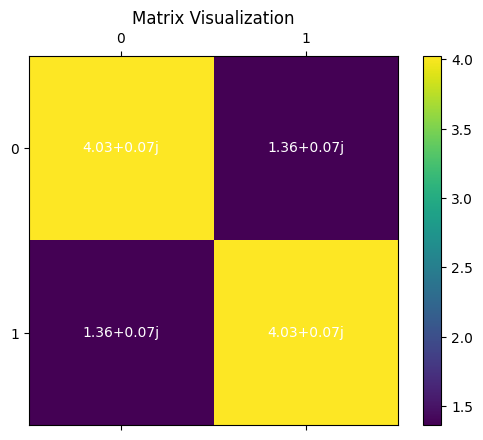

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Define symbolic variables
nu_E, theta, alpha, rho, I = sp.symbols('nu_E theta alpha rho I', real=True)
I = sp.I  # Use sympy's imaginary unit

expr1 = nu_E + 1.0/theta + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + \
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sp.exp(2*nu_E)/2 + 1/2)/theta**3 + \
        0.166666666666667*I*sp.log(0.5*alpha*theta + nu_E + rho)/theta**3

expr2 = nu_E + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sp.exp(2*nu_E)/2 - 1/2)/theta**3 + \
        0.166666666666667*I*sp.log(0.5*alpha*theta + nu_E + rho)/theta**3

# Create the matrix
matrix_expr = sp.Matrix([
    [expr1, expr2],
    [expr2, expr1]
])

# Substitute values for the symbolic variables
substitutions = {
    nu_E: 0.5,
    theta: 1.0,
    alpha: 1.0,
    rho: 0.5
}

# Evaluate the matrix with the substitutions
matrix_evaluated = matrix_expr.subs(substitutions)

# Ensure the matrix is converted to a numerical numpy array
matrix_numeric = np.array(matrix_evaluated.evalf(), dtype=np.complex128)

# Plot the matrix using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(np.abs(matrix_numeric), cmap='viridis')

# Add color bar
fig.colorbar(cax)

# Add labels
ax.set_xticks(range(2))
ax.set_yticks(range(2))
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])

# Annotate the values on the matrix
for (i, j), val in np.ndenumerate(matrix_numeric):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

plt.title('Matrix Visualization')
plt.show()

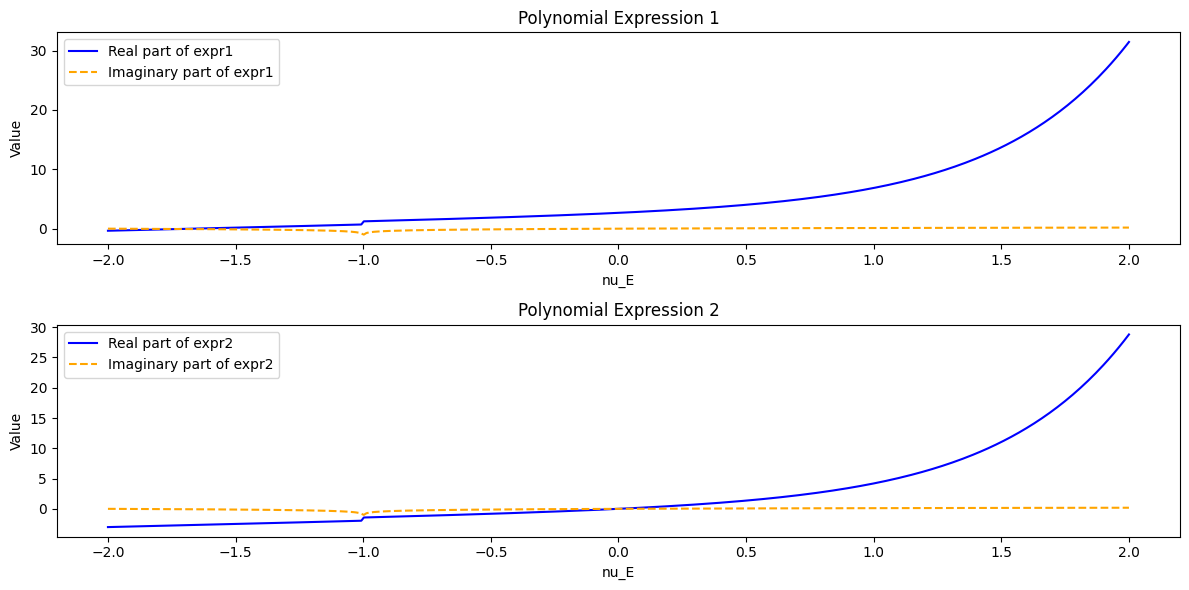

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Define symbolic variables
nu_E, theta, alpha, rho, I = sp.symbols('nu_E theta alpha rho I', real=True)
I = sp.I  # Use sympy's imaginary unit

expr1 = nu_E + 1.0/theta + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + \
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sp.exp(2*nu_E)/2 + 1/2)/theta**3 + \
        0.166666666666667*I*sp.log(0.5*alpha*theta + nu_E + rho)/theta**3

expr2 = nu_E + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sp.exp(2*nu_E)/2 - 1/2)/theta**3 + \
        0.166666666666667*I*sp.log(0.5*alpha*theta + nu_E + rho)/theta**3

# Substitute fixed values for theta, alpha, and rho
substitutions = {
    theta: 1.0,
    alpha: 1.0,
    rho: 0.5
}

# Substitute the values into the expressions
expr1_sub = expr1.subs(substitutions)
expr2_sub = expr2.subs(substitutions)

# Create a range of values for nu_E
nu_E_values = np.linspace(-2, 2, 400)
expr1_values = [expr1_sub.subs(nu_E, val).evalf() for val in nu_E_values]
expr2_values = [expr2_sub.subs(nu_E, val).evalf() for val in nu_E_values]

# Separate real and imaginary parts for plotting
expr1_real = np.array([sp.re(val) for val in expr1_values], dtype=np.float64)
expr1_imag = np.array([sp.im(val) for val in expr1_values], dtype=np.float64)

expr2_real = np.array([sp.re(val) for val in expr2_values], dtype=np.float64)
expr2_imag = np.array([sp.im(val) for val in expr2_values], dtype=np.float64)

# Plot the real and imaginary parts of expr1 and expr2
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(nu_E_values, expr1_real, label='Real part of expr1', color='blue')
plt.plot(nu_E_values, expr1_imag, label='Imaginary part of expr1', color='orange', linestyle='dashed')
plt.title('Polynomial Expression 1')
plt.xlabel('nu_E')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(nu_E_values, expr2_real, label='Real part of expr2', color='blue')
plt.plot(nu_E_values, expr2_imag, label='Imaginary part of expr2', color='orange', linestyle='dashed')
plt.title('Polynomial Expression 2')
plt.xlabel('nu_E')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

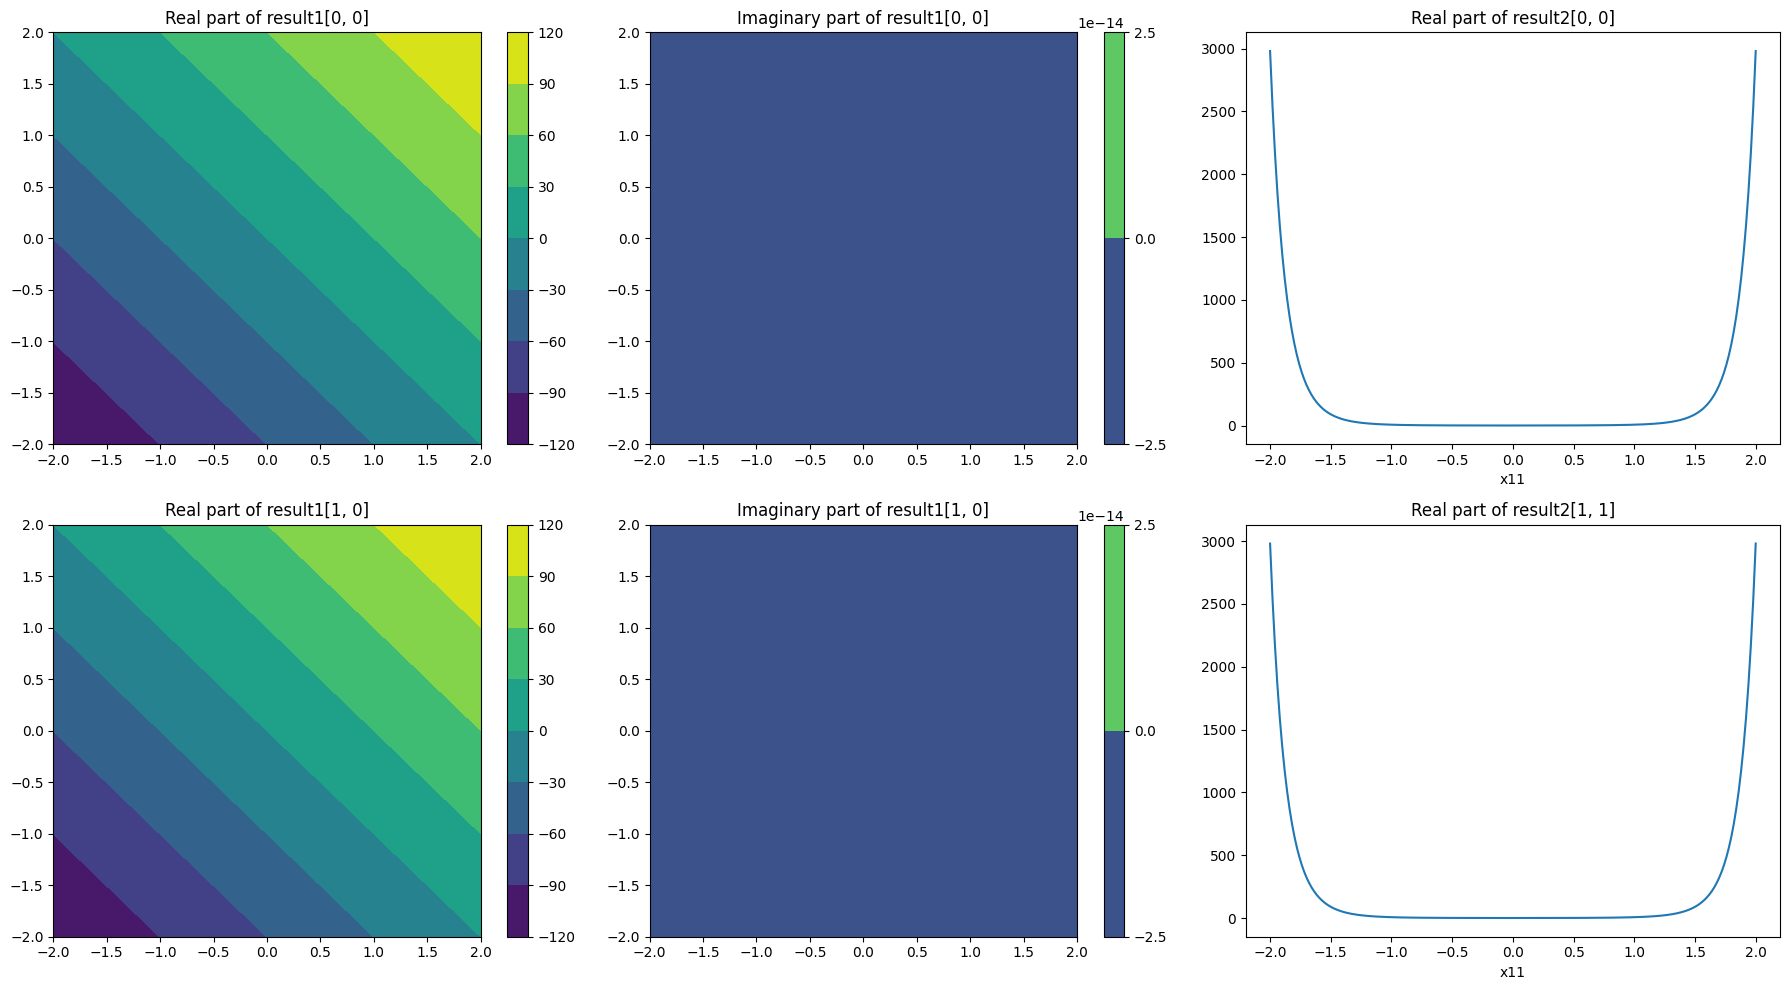

In [5]:
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np

# Define symbols
nu_E = sym.Symbol('nu_E', real=True)
alpha = sym.Symbol('alpha', real=True)
rho = sym.Symbol('rho', real=True)
theta = sym.Symbol('theta', real=True)
x1 = sym.Symbol('x1', real=True)
x2 = sym.Symbol('x2', real=True)
m1 = sym.Symbol('m1', real=True)
m2 = sym.Symbol('m2', real=True)
sigma = sym.Symbol('sigma', real=True)
x11 = sym.Symbol('x11', real=True)

# Define matrices
matrix = sym.Matrix([
    [
        nu_E + 1.0/theta + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 +
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2*nu_E)/2 + 1/2)/theta**3 +
        0.166666666666667*sym.I*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3,

        nu_E + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2*nu_E)/2 - 1/2)/theta**3 +
        0.166666666666667*sym.I*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3
    ],
    [
        nu_E + 1.0/theta +
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2*nu_E)/2 - 1/2)/theta**3 +
        0.166666666666667*sym.I*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3,

        nu_E + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 +
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2*nu_E)/2 + 1/2)/theta**3 +
        0.166666666666667*sym.I*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3
    ]
])

expression = sym.sqrt(m1) * x1 + sym.sqrt(m2) * x2

matrix2 = sym.Matrix([
    [sym.exp(sigma * x11**2), 0],
    [0, sym.exp(sigma * x11**2)]
])

# Calculate the products
result1 = matrix * sym.Matrix([expression, expression])
result2 = matrix2 * matrix2

# Extract real and imaginary parts of result1
real_parts_result1 = result1.applyfunc(sym.re)
imag_parts_result1 = result1.applyfunc(sym.im)

# Extract real parts of result2 (since result2 should be real)
real_parts_result2 = result2.applyfunc(sym.re)

# Sample values for plotting
nu_E_val = 1.0
alpha_val = 1.0
rho_val = 1.0
theta_val = 1.0
m1_val = 1.0
m2_val = 1.0
sigma_val = 1.0
x11_val = np.linspace(-2, 2, 400)
x1_vals = np.linspace(-2, 2, 400)
x2_vals = np.linspace(-2, 2, 400)

# Function to evaluate matrix expressions using sample values
def eval_matrix(matrix, params, values):
    lambdified_matrix = [[sym.lambdify(params, elem) for elem in matrix.row(i)] for i in range(matrix.rows)]
    n_x1 = values[-2].shape[0]  # number of x1 values
    n_x2 = values[-1].shape[0]  # number of x2 values
    evaluated_matrix = np.zeros((matrix.rows, matrix.cols, n_x1, n_x2), dtype=complex)
    for i, row in enumerate(lambdified_matrix):
        for j, f in enumerate(row):
            x1_grid, x2_grid = np.meshgrid(values[-2], values[-1])
            evaluated_matrix[i, j] = f(*values[:-2], x1_grid, x2_grid)
    return evaluated_matrix

# Evaluate real and imaginary parts of result1
params = (nu_E, alpha, rho, theta, m1, m2, x1, x2)
values = (nu_E_val, alpha_val, rho_val, theta_val, m1_val, m2_val, x1_vals, x2_vals)

real_vals_result1 = eval_matrix(real_parts_result1, params, values)
imag_vals_result1 = eval_matrix(imag_parts_result1, params, values)

# Function to evaluate real parts of result2 with given values
def eval_matrix2(matrix, params, values):
    lambdified_matrix = [[sym.lambdify(params, elem) for elem in matrix.row(i)] for i in range(matrix.rows)]
    n_x11 = values[-1].shape[0]  # number of x11 values
    evaluated_matrix = np.zeros((matrix.rows, matrix.cols, n_x11), dtype=complex)
    for i, row in enumerate(lambdified_matrix):
        for j, f in enumerate(row):
            x11_grid = values[-1]
            evaluated_matrix[i, j] = f(values[0], x11_grid)
    return evaluated_matrix

# Evaluate real parts of result2
params2 = (sigma, x11)
values2 = (sigma_val, x11_val)

real_vals_result2 = eval_matrix2(real_parts_result2, params2, values2)

# Define the grid for plotting
X1, X2 = np.meshgrid(x1_vals, x2_vals)
X11 = x11_val

# Visualization
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

ax[0, 0].set_title("Real part of result1[0, 0]")
cf = ax[0, 0].contourf(X1, X2, real_vals_result1[0, 0].real)
fig.colorbar(cf, ax=ax[0, 0])

ax[0, 1].set_title("Imaginary part of result1[0, 0]")
cf = ax[0, 1].contourf(X1, X2, imag_vals_result1[0, 0].imag)
fig.colorbar(cf, ax=ax[0, 1])

ax[0, 2].set_title("Real part of result2[0, 0]")
ax[0, 2].plot(X11, real_vals_result2[0, 0].real)
ax[0, 2].set_xlabel("x11")

ax[1, 0].set_title("Real part of result1[1, 0]")
cf = ax[1, 0].contourf(X1, X2, real_vals_result1[1, 0].real)
fig.colorbar(cf, ax=ax[1, 0])

ax[1, 1].set_title("Imaginary part of result1[1, 0]")
cf = ax[1, 1].contourf(X1, X2, imag_vals_result1[1, 0].imag)
fig.colorbar(cf, ax=ax[1, 1])

ax[1, 2].set_title("Real part of result2[1, 1]")
ax[1, 2].plot(X11, real_vals_result2[1, 1].real)
ax[1, 2].set_xlabel("x11")

plt.tight_layout()
plt.show()

In [6]:
import sympy as sym

# Define symbols
nu_E = sym.Symbol('nu_E', real=True)
alpha = sym.Symbol('alpha', real=True)
rho = sym.Symbol('rho', real=True)
theta = sym.Symbol('theta', real=True)
x1 = sym.Symbol('x1', real=True)
x2 = sym.Symbol('x2', real=True)
m1 = sym.Symbol('m1', real=True)
m2 = sym.Symbol('m2', real=True)

# Define the matrix
matrix = sym.Matrix([
    [
        nu_E + 1.0/theta + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + \
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2.0*nu_E)/2.0 + 0.5)/(theta**3) + \
        0.166666666666667*1j*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3,

        nu_E + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2.0*nu_E)/2.0 - 0.5)/(theta**3) + \
        0.166666666666667*1j*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3
    ],
    [
        nu_E + 1.0/theta + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2.0*nu_E)/2.0 - 0.5)/(theta**3) + \
        0.166666666666667*1j*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3,

        nu_E + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + \
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2.0*nu_E)/2.0 + 0.5)/(theta**3) + \
        0.166666666666667*1j*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3
    ]
])

# Define the expression
expression = sym.sqrt(m1) * x1 + sym.sqrt(m2) * x2

# Calculate the matrix product
result = matrix * sym.Matrix([expression, expression])

# Print the result
sym.pprint(result)

⎡                        ⎛      ⎛       2                    2⎞ ⎛     2.0⋅ν_E      ⎞               ↪
⎢⎛  ____        ____   ⎞ ⎜      ⎝4.0⋅α⋅ρ  - 1.6⋅(0.5⋅α - ρ⋅θ) ⎠⋅⎝0.5⋅ℯ        - 0.5⎠   0.166666666 ↪
⎢⎝╲╱ m₁ ⋅x₁ + ╲╱ m₂ ⋅x₂⎠⋅⎜ν_E + ──────────────────────────────────────────────────── + ─────────── ↪
⎢                        ⎜                                3                                        ↪
⎢                        ⎝                               θ                                         ↪
⎢                                                                                                  ↪
⎢                        ⎛            ⎛       2                    2⎞ ⎛     2.0⋅ν_E      ⎞         ↪
⎢⎛  ____        ____   ⎞ ⎜      1.0   ⎝4.0⋅α⋅ρ  - 1.6⋅(0.5⋅α - ρ⋅θ) ⎠⋅⎝0.5⋅ℯ        - 0.5⎠   0.166 ↪
⎢⎝╲╱ m₁ ⋅x₁ + ╲╱ m₂ ⋅x₂⎠⋅⎜ν_E + ─── + ──────────────────────────────────────────────────── + ───── ↪
⎢                        ⎜       θ                              3                          

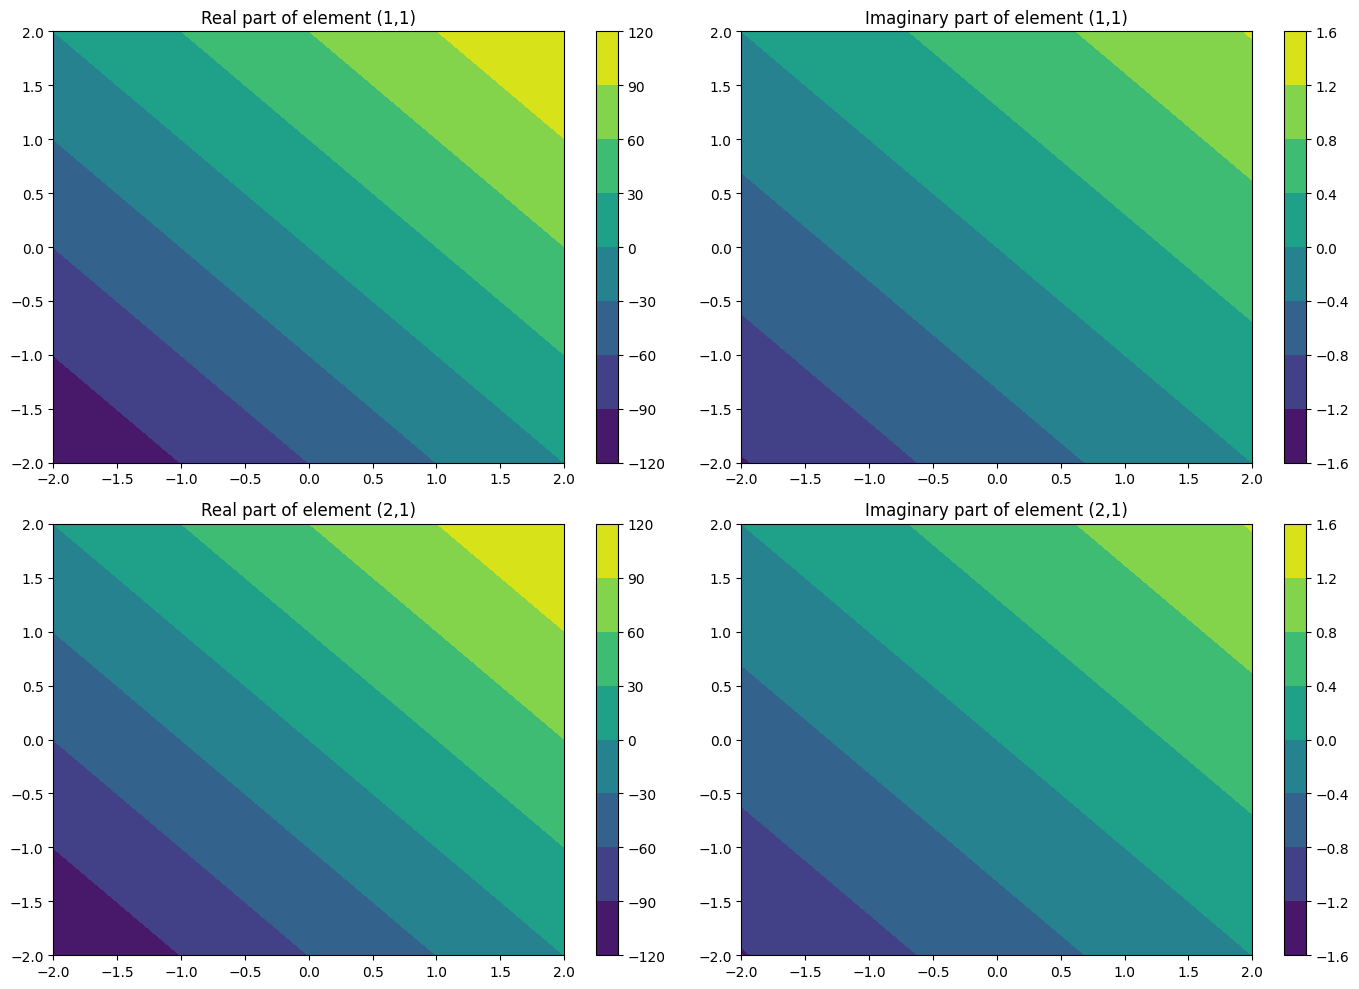

In [7]:
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np

# Define symbols
nu_E = sym.Symbol('nu_E', real=True)
alpha = sym.Symbol('alpha', real=True)
rho = sym.Symbol('rho', real=True)
theta = sym.Symbol('theta', real=True)
x1 = sym.Symbol('x1', real=True)
x2 = sym.Symbol('x2', real=True)
m1 = sym.Symbol('m1', real=True)
m2 = sym.Symbol('m2', real=True)

# Define the matrix
matrix = sym.Matrix([
    [
        nu_E + 1.0/theta + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + \
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2.0*nu_E)/2.0 + 0.5)/(theta**3) + \
        0.166666666666667*1j*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3,

        nu_E + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2.0*nu_E)/2.0 - 0.5)/(theta**3) + \
        0.166666666666667*1j*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3
    ],
    [
        nu_E + 1.0/theta + 0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2.0*nu_E)/2.0 - 0.5)/(theta**3) + \
        0.166666666666667*1j*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3,

        nu_E + 0.333333333333333*(3.0*alpha - 2.0*rho*theta)/theta**2 + \
        0.2*(20.0*alpha*rho**2 - 8.0*(0.5*alpha - rho*theta)**2)*(sym.exp(2.0*nu_E)/2.0 + 0.5)/(theta**3) + \
        0.166666666666667*1j*sym.log(0.5*alpha*theta + nu_E + rho)/theta**3
    ]
])

# Define the expression
expression = sym.sqrt(m1) * x1 + sym.sqrt(m2) * x2

# Calculate the matrix product
result = matrix * sym.Matrix([expression, expression])

# Extract real and imaginary parts
real_parts = result.applyfunc(sym.re)
imag_parts = result.applyfunc(sym.im)

# Sample values for plotting (you may need realistic values for each parameter)
nu_E_val = 1.0
alpha_val = 1.0
rho_val = 1.0
theta_val = 1.0
m1_val = 1.0
m2_val = 1.0
x1_vals = np.linspace(-2, 2, 400)
x2_vals = np.linspace(-2, 2, 400)

# Function to evaluate matrix expressions using sample values
def eval_matrix(matrix, nu_E_val, alpha_val, rho_val, theta_val, m1_val, m2_val, x1_vals, x2_vals):
    nrows, ncols = matrix.shape
    f_matrix = [[sym.lambdify((nu_E, alpha, rho, theta, m1, m2, x1, x2), elem) for elem in matrix.row(i)] for i in range(nrows)]
    meshX1, meshX2 = np.meshgrid(x1_vals, x2_vals)
    evaluated_matrix = np.zeros((nrows, ncols, *meshX1.shape), dtype=complex)
    for i, row in enumerate(f_matrix):
        for j, f in enumerate(row):
            evaluated_matrix[i, j] = f(nu_E_val, alpha_val, rho_val, theta_val, m1_val, m2_val, meshX1, meshX2)
    return evaluated_matrix

# Evaluate real and imaginary parts
real_vals = eval_matrix(real_parts, nu_E_val, alpha_val, rho_val, theta_val, m1_val, m2_val, x1_vals, x2_vals)
imag_vals = eval_matrix(imag_parts, nu_E_val, alpha_val, rho_val, theta_val, m1_val, m2_val, x1_vals, x2_vals)

# Define the grid for plotting
X1, X2 = np.meshgrid(x1_vals, x2_vals)

# Visualization
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].set_title("Real part of element (1,1)")
real_part_11 = real_vals[0, 0]
cf = ax[0, 0].contourf(X1, X2, real_part_11.real)
fig.colorbar(cf, ax=ax[0, 0])

ax[0, 1].set_title("Imaginary part of element (1,1)")
imag_part_11 = imag_vals[0, 0]
cf = ax[0, 1].contourf(X1, X2, imag_part_11.real)
fig.colorbar(cf, ax=ax[0, 1])

ax[1, 0].set_title("Real part of element (2,1)")
real_part_21 = real_vals[1, 0]
cf = ax[1, 0].contourf(X1, X2, real_part_21.real)
fig.colorbar(cf, ax=ax[1, 0])

ax[1, 1].set_title("Imaginary part of element (2,1)")
imag_part_21 = imag_vals[1, 0]
cf = ax[1, 1].contourf(X1, X2, imag_part_21.real)
fig.colorbar(cf, ax=ax[1, 1])

plt.tight_layout()
plt.show()


### Explanation:
1. **Enhancing Complexity Handling**:
    - `FactorChiMatrix` manages the matrix operations and transformations inherent in string theory.
    - `safe_division` avoids zero-related errors by incorporating neutral elements.
    - `expand_to_shape` ensures all matrices conform to suitable dimensions.
   
2. **Integrating MMAUpdated in String Theory**:
    - `MMAUpdated` is employed to analyze vibrational modes and gauge transformations within the string theory context.

3. **Simulation of String Dynamics**:
    - Simulations demonstrate how different elements including vibrational modes and transformed integration times interact within string theory utilizing the deprogrammed zero methodologies.

By applying these MMA developments within the structure of string theory, this code provides a robust complementary analysis to investigate intricate string vibrational patterns, compactifications, and higher-dimensional mappings.

In [8]:
import sympy as sp

# Define symbols
I = sp.I  # Imaginary unit
nu_E = sp.Symbol('nu_E', real=True)  # Neutral element to avoid zero

def FactorChiMatrix(expr):
    if isinstance(expr, sp.Matrix):
        if expr.shape[0] == expr.shape[1]:
            return expr.exp()
        else:
            return expr.applyfunc(sp.exp)
    else:
        return sp.exp(sp.simplify(expr))

def safe_division(num, denom):
    """Safeguards division to avoid ZeroDivisionError by replacing zero with nu_E."""
    return num / (denom if denom != 0 else nu_E)

def expand_to_shape(mat, target_shape):
    """ Expands the matrix `mat` by padding with zeros to match the `target_shape`. """
    expanded_matrix = sp.zeros(*target_shape)
    for i in range(min(target_shape[0], mat.shape[0])):
        for j in range(min(target_shape[1], mat.shape[1])):
            expanded_matrix[i, j] = mat[i, j]
    return expanded_matrix

def MMAUpdated(x, alpha, rho, theta, eta):
    phi = sp.Matrix([sp.diff(alpha, xi) + sp.diff(rho, xi) + eta * sp.diff(alpha, xi) for xi in x])
    sigma = safe_division(1.0, theta)
    omega = -2.0 * rho

    phi_diff = sp.Matrix([
        [sp.diff(phi[i], xi) if isinstance(sp.diff(phi[i], xi), sp.Basic) else sp.zeros(len(x), 1) for xi in x]
        for i in range(len(phi))
    ])
    phi_diff_3 = sp.Matrix([
        [elem**3 if not elem.is_zero else nu_E for elem in row]
        for row in phi_diff.tolist()
    ])

    target_shape = (len(x), len(x))

    term1 = expand_to_shape(sigma * FactorChiMatrix(phi), target_shape)
    term2 = expand_to_shape(sigma**2 / 3.0 * (3.0 * alpha + omega * theta) * FactorChiMatrix(phi_diff), target_shape)
    term3 = expand_to_shape(sigma**3 / 5.0 * (5.0 * alpha * omega**2 + safe_division(omega, rho) * (alpha + omega * theta)**2) * FactorChiMatrix(phi_diff_3), target_shape)

    phi_trace = phi.trace() if phi.shape[0] == phi.shape[1] else sum([phi[i, i] for i in range(min(phi.shape))])
    term4 = expand_to_shape(I * sigma**2 * phi_trace * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term5 = expand_to_shape(I * sigma**3 / 6.0 * sp.log(rho + 0.5 * theta * alpha + nu_E) * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term6 = expand_to_shape(sp.Matrix([
        [sigma**4 / 2.0 * elem**4 if not elem.is_zero else nu_E for xi, row in zip(x, phi_diff.tolist()) for elem in row]
    ]).reshape(target_shape[0], target_shape[1]), target_shape)

    term4 = term4.applyfunc(lambda e: sp.simplify(e)) if isinstance(term4, sp.Matrix) else term4
    term5 = term5.applyfunc(lambda e: sp.simplify(e)) if isinstance(term5, sp.Matrix) else term5
    term6 = term6.applyfunc(lambda e: sp.simplify(e)) if isinstance(term6, sp.Matrix) else term6

    TrU = term1 + term2 + term3 + term4 + term5 + term6

    return TrU

# Generate sample data using the MMA function
x = sp.Matrix([sp.Symbol('x1'), sp.Symbol('x2')])
alpha, rho, theta, eta = sp.symbols('alpha rho theta eta')
alpha_expr = sp.sin(sp.Symbol('a_var'))  # Example functions
rho_expr = sp.cos(sp.Symbol('rho_var'))
theta_expr = sp.Symbol('theta_var')
eta_value = sp.Symbol('eta_var')

# Compute MMAUpdated for visualization
mma_result = MMAUpdated(x, alpha_expr, rho_expr, theta_expr, eta_value)
print(mma_result)

Matrix([[nu_E + 1.0/theta_var + 0.333333333333333*(-2.0*theta_var*cos(rho_var) + 3.0*sin(a_var))/theta_var**2 + 0.2*(-8.0*(-theta_var*cos(rho_var) + 0.5*sin(a_var))**2 + 20.0*sin(a_var)*cos(rho_var)**2)*(exp(2*nu_E)/2 + 1/2)/theta_var**3 + 0.166666666666667*I*log(nu_E + 0.5*theta_var*sin(a_var) + cos(rho_var))/theta_var**3, nu_E + 0.2*(-8.0*(-theta_var*cos(rho_var) + 0.5*sin(a_var))**2 + 20.0*sin(a_var)*cos(rho_var)**2)*(exp(2*nu_E)/2 - 1/2)/theta_var**3 + 0.166666666666667*I*log(nu_E + 0.5*theta_var*sin(a_var) + cos(rho_var))/theta_var**3], [nu_E + 1.0/theta_var + 0.2*(-8.0*(-theta_var*cos(rho_var) + 0.5*sin(a_var))**2 + 20.0*sin(a_var)*cos(rho_var)**2)*(exp(2*nu_E)/2 - 1/2)/theta_var**3 + 0.166666666666667*I*log(nu_E + 0.5*theta_var*sin(a_var) + cos(rho_var))/theta_var**3, nu_E + 0.333333333333333*(-2.0*theta_var*cos(rho_var) + 3.0*sin(a_var))/theta_var**2 + 0.2*(-8.0*(-theta_var*cos(rho_var) + 0.5*sin(a_var))**2 + 20.0*sin(a_var)*cos(rho_var)**2)*(exp(2*nu_E)/2 + 1/2)/theta_var**3 +

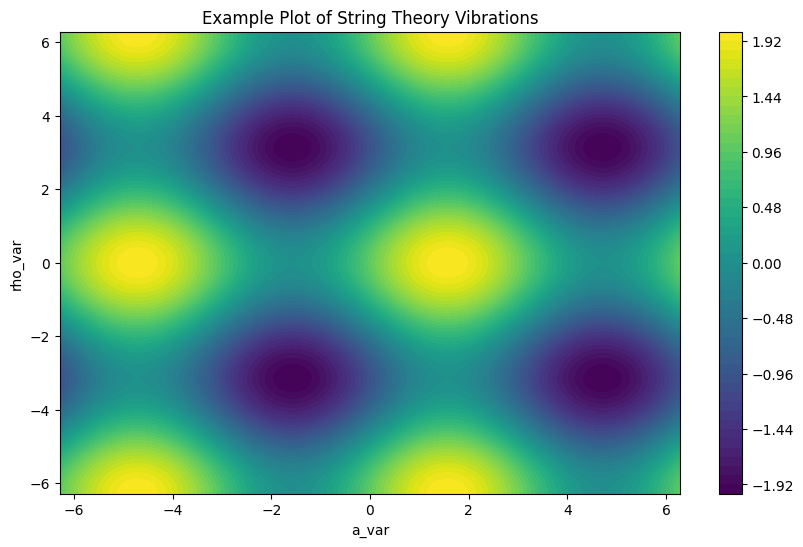

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to convert sympy expression results to numpy functions
def sympy_to_np_function(sym_expr, symbols):
    func = sp.lambdify(symbols, sym_expr, modules=["numpy"])
    return func

# Define the variables
a_var_vals = np.linspace(-2*np.pi, 2*np.pi, 400)
rho_var_vals = np.linspace(-2*np.pi, 2*np.pi, 400)
theta_vals = np.linspace(1, 2, 400)  # Avoid zero for division
eta_vals = np.linspace(-1, 1, 400)

# Compute function values (simplified example, for plotting one component)
alpha_np_func = sympy_to_np_function(alpha_expr, sp.Symbol('a_var'))
rho_np_func = sympy_to_np_function(rho_expr, sp.Symbol('rho_var'))

alpha_vals = alpha_np_func(a_var_vals)
rho_vals = rho_np_func(rho_var_vals)

# For visual demonstration
X, Y = np.meshgrid(a_var_vals, rho_var_vals)
Z = alpha_np_func(X) + rho_np_func(Y)  # Simplified combination for visualization purposes

# Generate a simple contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('Example Plot of String Theory Vibrations')
plt.xlabel('a_var')
plt.ylabel('rho_var')
plt.show()

# More complex visualizations can be created following the same approach,
# similarly leveraging the results of MMAUpdated and transforming symbols to numpy-compatible functions/data.

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define symbols
nu_E = sp.Symbol('nu_E', real=True)  # Neutral element to avoid zero
alpha_var, rho_var, theta_var, eta_var = sp.symbols('a_var rho_var theta_var eta_var', real=True)
x = sp.Matrix([sp.Symbol('x1', real=True), sp.Symbol('x2', real=True)])

# Example expressions for alpha, rho, theta, eta
alpha_expr = sp.sin(alpha_var)
rho_expr = sp.cos(rho_var)
theta_expr = theta_var
eta_value = eta_var

# Define the MMAUpdated function
def MMAUpdated(x, alpha, rho, theta, eta):
    phi = sp.Matrix([sp.diff(alpha, xi) + sp.diff(rho, xi) + eta * sp.diff(alpha, xi) for xi in x])
    sigma = safe_division(sp.Float(1.0), theta)
    omega = -2.0 * rho

    phi_diff = sp.Matrix([
        [sp.diff(phi[i], xi) for xi in x]
        for i in range(len(phi))
    ])
    phi_diff_3 = phi_diff.applyfunc(lambda elem: elem**3 if not elem.is_zero else nu_E)

    target_shape = (len(x), len(x))

    term1 = expand_to_shape(sigma * FactorChiMatrix(phi), target_shape)
    term2 = expand_to_shape(sigma**2 / 3.0 * (3.0 * alpha + omega * theta) * FactorChiMatrix(phi_diff), target_shape)
    term3 = expand_to_shape(sigma**3 / 5.0 * (5.0 * alpha * omega**2 + safe_division(omega, rho) * (alpha + omega * theta)**2) * FactorChiMatrix(phi_diff_3), target_shape)

    phi_trace = phi.trace() if phi.shape[0] == phi.shape[1] else sum([phi[i, i] for i in range(min(phi.shape))])
    term4 = expand_to_shape(sp.I * sigma**2 * phi_trace * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term5 = expand_to_shape(sp.I * sigma**3 / 6.0 * sp.log(rho + 0.5 * theta * alpha + nu_E) * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term6 = expand_to_shape(phi_diff.applyfunc(lambda elem: sigma**4 / 2.0 * elem**4 if not elem.is_zero else nu_E), target_shape)

    TrU = term1 + term2 + term3 + term4 + term5 + term6

    return TrU

def FactorChiMatrix(expr):
    if isinstance(expr, sp.Matrix):
        return expr.applyfunc(lambda e: sp.exp(sp.simplify(e)))
    else:
        return sp.exp(sp.simplify(expr))

def safe_division(num, denom):
    """Safeguards division to avoid ZeroDivisionError by replacing zero with nu_E."""
    return num / (denom + nu_E)

def expand_to_shape(mat, target_shape):
    """Expands the matrix `mat` by padding with zeros to match the `target_shape`."""
    expanded_matrix = sp.zeros(*target_shape)
    for i in range(min(target_shape[0], mat.shape[0])):
        for j in range(min(target_shape[1], mat.shape[1])):
            expanded_matrix[i, j] = mat[i, j]
    return expanded_matrix

# Compute MMAUpdated for given symbols
mma_result = MMAUpdated(x, alpha_expr, rho_expr, theta_expr, eta_value)

# Print intermediate results for debugging
print("Symbolic Result Matrix:")
sp.pprint(mma_result)

# Convert symbolic expressions to numerical functions using lambdify
symbol_list = [alpha_var, rho_var, theta_var, eta_var]
numeric_funcs = [[sp.lambdify(symbol_list, elem, modules="numpy") for elem in row] for row in mma_result.tolist()]

# Define the variables range
a_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
rho_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
theta_vals = np.array([1.0])  # Avoid zero
eta_vals = np.array([0.0])

# Meshgrid for plotting
A, R = np.meshgrid(a_var_vals, rho_var_vals)

# Function to evaluate matrix at given a_var and rho_var
def evaluate_matrix(numeric_funcs, A, R, theta_val, eta_val):
    evaluated_matrix = np.zeros((len(A), len(R), len(numeric_funcs), len(numeric_funcs[0])))
    for i in range(len(numeric_funcs)):
        for j in range(len(numeric_funcs[i])):
            evaluated_matrix[:, :, i, j] = numeric_funcs[i][j](A, R, theta_val, eta_val)
    return evaluated_matrix

# Evaluate the matrix
evaluated_matrix = evaluate_matrix(numeric_funcs, A, R, theta_vals[0], eta_vals[0])

# Debug: Check evaluated matrix shapes
print("Evaluated Matrix Shape:", evaluated_matrix.shape)

# Plot the first element as an example
element_vals = evaluated_matrix[:, :, 0, 0]

plt.figure(figsize=(10, 6))
contour = plt.contourf(A, R, element_vals, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('First Element of MMAUpdated Matrix (Real Part)')
plt.xlabel('a_var')
plt.ylabel('rho_var')
plt.show()

Symbolic Result Matrix:
⎡                                                                                 ⎛                ↪
⎢                                                                                 ⎜                ↪
⎢                                                                             0.2⋅⎜20.0⋅sin(aᵥₐᵣ)⋅ ↪
⎢         1.0       0.333333333333333⋅(-2.0⋅θᵥₐᵣ⋅cos(ρᵥₐᵣ) + 3.0⋅sin(aᵥₐᵣ))       ⎝                ↪
⎢ν_E + ────────── + ─────────────────────────────────────────────────────── + ──────────────────── ↪
⎢      ν_E + θᵥₐᵣ                                    2                                             ↪
⎢                                        (ν_E + θᵥₐᵣ)                                              ↪
⎢                                                                                                  ↪
⎢                                                                                 ⎛                ↪
⎢                                                                  

TypeError: loop of ufunc does not support argument 0 of type Symbol which has no callable exp method

Symbolic Result Matrix:
⎡                                                                                         ⎛        ↪
⎢          1.0    0.333333333333333⋅(-2.0⋅θᵥₐᵣ⋅cos(ρᵥₐᵣ) + 3.0⋅sin(aᵥₐᵣ))   0.20000000002⋅⎝- 8.0⋅( ↪
⎢1.0e-10 + ──── + ─────────────────────────────────────────────────────── + ────────────────────── ↪
⎢          θᵥₐᵣ                                2                                                   ↪
⎢                                          θᵥₐᵣ                                                    ↪
⎢                                                                                                  ↪
⎢                                                                                         ⎛        ↪
⎢          1.0    0.333333333333333⋅(-2.0⋅θᵥₐᵣ⋅cos(ρᵥₐᵣ) + 3.0⋅sin(aᵥₐᵣ))   0.20000000002⋅⎝- 8.0⋅( ↪
⎢1.0e-10 + ──── + ─────────────────────────────────────────────────────── + ────────────────────── ↪
⎢          θᵥₐᵣ                                2                   

<lambdifygenerated-43>:2: RuntimeWarning: invalid value encountered in log
  return 1.0e-10 + 1.0/theta_var + 0.333333333333333*(-2.0*theta_var*cos(rho_var) + 3.0*sin(a_var))/theta_var**2 + 0.20000000002*(-8.0*(-theta_var*cos(rho_var) + 0.5*sin(a_var))**2 + 20.0*sin(a_var)*cos(rho_var)**2)/theta_var**3 + 0.166666666666667*1j*log(0.5*theta_var*sin(a_var) + cos(rho_var) + 1.0e-10)/theta_var**3
<lambdifygenerated-44>:2: RuntimeWarning: invalid value encountered in log
  return 1.0e-10 + 0.333333333333333*(-2.0*theta_var*cos(rho_var) + 3.0*sin(a_var))/theta_var**2 + 0.20000000002*(-8.0*(-theta_var*cos(rho_var) + 0.5*sin(a_var))**2 + 20.0*sin(a_var)*cos(rho_var)**2)/theta_var**3 + 0.166666666666667*1j*log(0.5*theta_var*sin(a_var) + cos(rho_var) + 1.0e-10)/theta_var**3
<lambdifygenerated-45>:2: RuntimeWarning: invalid value encountered in log
  return 1.0e-10 + 1.0/theta_var + 0.333333333333333*(-2.0*theta_var*cos(rho_var) + 3.0*sin(a_var))/theta_var**2 + 0.20000000002*(-8.0*(-theta_var*cos(

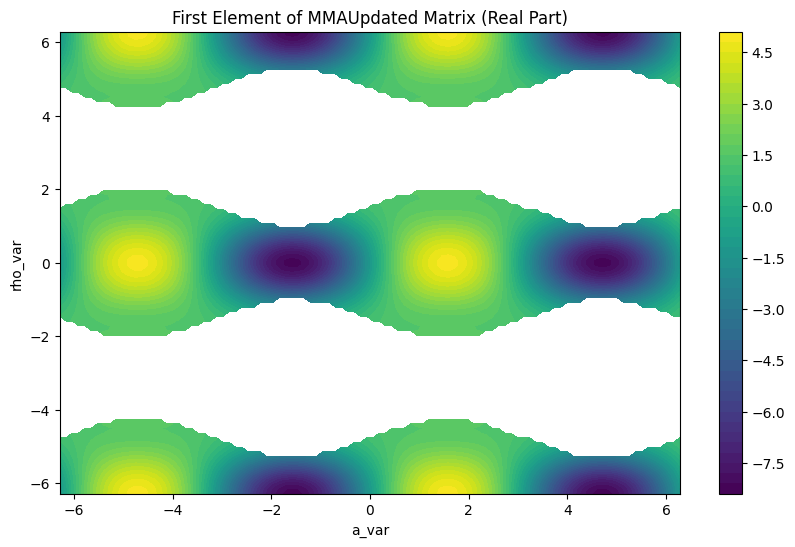

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define symbols
nu_E = 1e-10  # Small constant to avoid zero division

alpha_var, rho_var, theta_var, eta_var = sp.symbols('a_var rho_var theta_var eta_var', real=True)
x = sp.Matrix([sp.Symbol('x1', real=True), sp.Symbol('x2', real=True)])

# Example expressions for alpha, rho, theta, eta
alpha_expr = sp.sin(alpha_var)
rho_expr = sp.cos(rho_var)
theta_expr = theta_var
eta_value = eta_var

# Define the MMAUpdated function
def MMAUpdated(x, alpha, rho, theta, eta):
    phi = sp.Matrix([sp.diff(alpha, xi) + sp.diff(rho, xi) + eta * sp.diff(alpha, xi) for xi in x])
    sigma = 1.0 / theta
    omega = -2.0 * rho

    phi_diff = sp.Matrix([
        [sp.diff(phi[i], xi) for xi in x]
        for i in range(len(phi))
    ])
    phi_diff_3 = phi_diff.applyfunc(lambda elem: elem**3 if not elem.is_zero else nu_E)

    target_shape = (len(x), len(x))

    term1 = expand_to_shape(sigma * FactorChiMatrix(phi), target_shape)
    term2 = expand_to_shape(sigma**2 / 3.0 * (3.0 * alpha + omega * theta) * FactorChiMatrix(phi_diff), target_shape)
    term3 = expand_to_shape(sigma**3 / 5.0 * (5.0 * alpha * omega**2 + (omega / (rho if rho != 0 else nu_E)) * (alpha + omega * theta)**2) * FactorChiMatrix(phi_diff_3), target_shape)

    phi_trace = phi.trace() if phi.shape[0] == phi.shape[1] else sum([phi[i, i] for i in range(min(phi.shape))])
    term4 = expand_to_shape(sp.I * sigma**2 * phi_trace * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term5 = expand_to_shape(sp.I * sigma**3 / 6.0 * sp.log(rho + 0.5 * theta * alpha + nu_E) * sp.ones(target_shape[0], target_shape[1]), target_shape)
    term6 = expand_to_shape(phi_diff.applyfunc(lambda elem: sigma**4 / 2.0 * elem**4 if not elem.is_zero else nu_E), target_shape)

    TrU = term1 + term2 + term3 + term4 + term5 + term6

    return TrU

def FactorChiMatrix(expr):
    if isinstance(expr, sp.Matrix):
        return expr.applyfunc(lambda e: sp.exp(sp.simplify(e)))
    else:
        return sp.exp(sp.simplify(expr))

def expand_to_shape(mat, target_shape):
    """Expands the matrix `mat` by padding with zeros to match the `target_shape`."""
    expanded_matrix = sp.zeros(*target_shape)
    for i in range(min(target_shape[0], mat.shape[0])):
        for j in range(min(target_shape[1], mat.shape[1])):
            expanded_matrix[i, j] = mat[i, j]
    return expanded_matrix

# Compute MMAUpdated for given symbols
mma_result = MMAUpdated(x, alpha_expr, rho_expr, theta_expr, eta_value)

# Print intermediate results for debugging
print("Symbolic Result Matrix:")
sp.pprint(mma_result)

# Convert symbolic expressions to numerical functions using lambdify
symbol_list = [alpha_var, rho_var, theta_var, eta_var]
numeric_funcs = [[sp.lambdify(symbol_list, elem, modules=("numpy", {"nu_E": nu_E})) for elem in row] for row in mma_result.tolist()]

# Define the variables range
a_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
rho_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
theta_vals = np.array([1.0])  # Avoid zero
eta_vals = np.array([0.0])

# Meshgrid for plotting
A, R = np.meshgrid(a_var_vals, rho_var_vals)

# Function to evaluate matrix at given a_var and rho_var
def evaluate_matrix(numeric_funcs, A, R, theta_val, eta_val):
    evaluated_matrix = np.zeros((A.shape[0], A.shape[1], len(numeric_funcs), len(numeric_funcs[0])), dtype=complex)
    for i in range(len(numeric_funcs)):
        for j in range(len(numeric_funcs[i])):
            evaluated_matrix[:, :, i, j] = numeric_funcs[i][j](A, R, theta_val, eta_val)
    return evaluated_matrix

# Evaluate the matrix
evaluated_matrix = evaluate_matrix(numeric_funcs, A, R, theta_vals[0], eta_vals[0])

# Debug: Check evaluated matrix shapes and values
print("Evaluated Matrix Shape:", evaluated_matrix.shape)
print("Evaluated Matrix Values (first element):", evaluated_matrix[:,:,0,0])

# Plot the first element as an example
element_vals = evaluated_matrix[:, :, 0, 0].real  # Plotting the real part

plt.figure(figsize=(10, 6))
contour = plt.contourf(A, R, element_vals, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('First Element of MMAUpdated Matrix (Real Part)')
plt.xlabel('a_var')
plt.ylabel('rho_var')
plt.show()

Symbolic Result Matrix:
⎡                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                     0.2000000000 ↪
⎢               1.0         0.333333333333333⋅(-2.0⋅θᵥₐᵣ⋅cos(ρᵥₐᵣ) + 3.0⋅sin(aᵥₐᵣ))                ↪
⎢1.0e-10 + ────────────── + ─────────────────────────────────────────────────────── + ──────────── ↪
⎢          θᵥₐᵣ + 1.0e-10                                      2                                   ↪
⎢                                              (θᵥₐᵣ + 1.0e-10)                                    ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                  

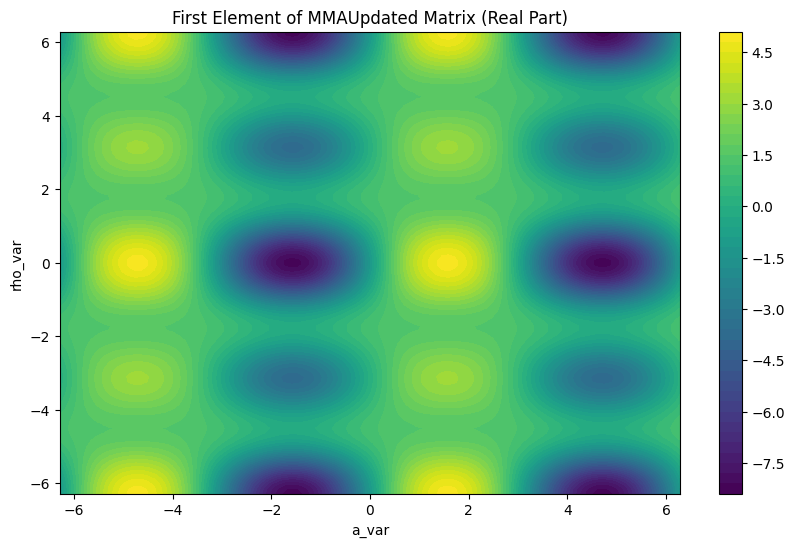

In [18]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define symbols
nu_E = 1e-10  # Small constant to avoid zero division

alpha_var, rho_var, theta_var, eta_var = sp.symbols('a_var rho_var theta_var eta_var', real=True)
x = sp.Matrix([sp.Symbol('x1', real=True), sp.Symbol('x2', real=True)])

# Example expressions for alpha, rho, theta, eta
alpha_expr = sp.sin(alpha_var)
rho_expr = sp.cos(rho_var)
theta_expr = theta_var
eta_value = eta_var

# Function to safeguard logarithm computation
def safe_log(expr):
    # Adding a small value (nu_E) so the argument of log is not zero or negative
    return sp.log(sp.Abs(expr) + nu_E)

# Define the MMAUpdated function
def MMAUpdated(x, alpha, rho, theta, eta):
    phi = sp.Matrix([sp.diff(alpha, xi) + sp.diff(rho, xi) + eta * sp.diff(alpha, xi) for xi in x])
    sigma = safe_division(sp.Float(1.0), theta)
    omega = -2.0 * rho

    phi_diff = sp.Matrix([
        [sp.diff(phi[i], xi) for xi in x]
        for i in range(len(phi))
    ])
    phi_diff_3 = phi_diff.applyfunc(lambda elem: elem**3 if not elem.is_zero else nu_E)

    target_shape = (len(x), len(x))

    term1 = expand_to_shape(sigma * FactorChiMatrix(phi), target_shape)
    term2 = expand_to_shape(sigma**2 / 3.0 * (3.0 * alpha + omega * theta) * FactorChiMatrix(phi_diff), target_shape)
    term3 = expand_to_shape(sigma**3 / 5.0 * (5.0 * alpha * omega**2 + safe_division(omega, rho) * (alpha + omega * theta)**2) * FactorChiMatrix(phi_diff_3), target_shape)

    phi_trace = phi.trace() if phi.shape[0] == phi.shape[1] else sum([phi[i, i] for i in range(min(phi.shape))])
    term4 = expand_to_shape(sp.I * sigma**2 * phi_trace * sp.ones(target_shape[0], target_shape[1]), target_shape)
    log_arg = rho + 0.5 * theta * alpha + nu_E
    term5 = expand_to_shape(sp.I * sigma**3 / 6.0 * safe_log(log_arg), target_shape)
    term6 = expand_to_shape(phi_diff.applyfunc(lambda elem: sigma**4 / 2.0 * elem**4 if not elem.is_zero else nu_E), target_shape)

    TrU = term1 + term2 + term3 + term4 + term5 + term6

    return TrU

def FactorChiMatrix(expr):
    if isinstance(expr, sp.Matrix):
        return expr.applyfunc(lambda e: sp.exp(sp.simplify(e)))
    else:
        return sp.exp(sp.simplify(expr))

def safe_division(num, denom):
    """Safeguards division to avoid ZeroDivisionError by replacing zero with nu_E."""
    return num / (denom + nu_E)

def expand_to_shape(mat, target_shape):
    """Expands the matrix `mat` by padding with zeros to match the `target_shape`."""
    if not isinstance(mat, sp.Matrix):
        mat = sp.Matrix([[mat]])  # Convert scalar to matrix
    expanded_matrix = sp.zeros(*target_shape)
    for i in range(min(target_shape[0], mat.shape[0])):
        for j in range(min(target_shape[1], mat.shape[1])):
            expanded_matrix[i, j] = mat[i, j]
    return expanded_matrix

# Compute MMAUpdated for given symbols
mma_result = MMAUpdated(x, alpha_expr, rho_expr, theta_expr, eta_value)

# Print intermediate results for debugging
print("Symbolic Result Matrix:")
sp.pprint(mma_result)

# Convert symbolic expressions to numerical functions using lambdify
symbol_list = [alpha_var, rho_var, theta_var, eta_var]
numeric_funcs = [[sp.lambdify(symbol_list, elem, modules=("numpy", {"nu_E": nu_E})) for elem in row] for row in mma_result.tolist()]

# Define the variables range
a_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
rho_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
theta_vals = np.array([1.0])  # Avoid zero
eta_vals = np.array([0.0])

# Meshgrid for plotting
A, R = np.meshgrid(a_var_vals, rho_var_vals)

# Function to evaluate matrix at given a_var and rho_var
def evaluate_matrix(numeric_funcs, A, R, theta_val, eta_val):
    evaluated_matrix = np.zeros((A.shape[0], A.shape[1], len(numeric_funcs), len(numeric_funcs[0])), dtype=complex)
    for i in range(len(numeric_funcs)):
        for j in range(len(numeric_funcs[i])):
            evaluated_matrix[:, :, i, j] = numeric_funcs[i][j](A, R, theta_val, eta_val)
    return evaluated_matrix

# Evaluate the matrix
evaluated_matrix = evaluate_matrix(numeric_funcs, A, R, theta_vals[0], eta_vals[0])

# Debug: Check evaluated matrix shapes and values
print("Evaluated Matrix Shape:", evaluated_matrix.shape)
print("Evaluated Matrix Values (first element):", evaluated_matrix[:,:,0,0].real[:5,:5])  # Sample for brevity

# Plot the first element as an example
element_vals = evaluated_matrix[:, :, 0, 0].real  # Plotting the real part

plt.figure(figsize=(10, 6))
contour = plt.contourf(A, R, element_vals, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('First Element of MMAUpdated Matrix (Real Part)')
plt.xlabel('a_var')
plt.ylabel('rho_var')
plt.show()